<a href="https://colab.research.google.com/github/van-thiep/A-Time-Aware-CNN-Based-Personalized-Recommender-System/blob/master/Context_Recomender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

Trong phần này mình sẽ sử dụng dữ liệu google analytics được thu thập từ một trang báo điện tử để xây dựng hệ thống khuyến nghị (recommendation system) sử dụng  Time-Aware CNN-Based Personalized Recommender System. Tôi cũng sử dụng custom estimator để train, eval and predict. Để có thể tạo custom estimator, các bạn có thể tham khảo tại [Creating Custom Estimators](https://docs.w3cub.com/tensorflow~guide/get_started/custom_estimators/) hoặc [Creating Custom Estimators in TensorFlow](https://developers.googleblog.com/2017/12/creating-custom-estimators-in-tensorflow.html)


# Get raw data

## Set up for using big query on google colab

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


## Get implicit feedback with context

In [ ]:
%%bigquery --project one-mount-group-sql-test implicit_feedback
WITH visitor_page_content AS (
 SELECT  
     fullVisitorID ,hits.time,
     case 
     when (extract(hour from timestamp_seconds(visitStartTime))) between 9 and 20
     then 'worked_time'
     else 'free_time'
     end as time_context,
     case 
     when (extract(DAYOFWEEK from timestamp_seconds(visitStartTime))) between 2 and 6
     then 'weekday'
     else 'weekkend'
     end as day_context     ,
     (SELECT MAX(IF(index=10, value, NULL)) FROM UNNEST(hits.customDimensions)) AS latestContentId,  
     (LEAD(hits.time, 1) OVER (PARTITION BY fullVisitorId ORDER BY hits.time ASC) - hits.time) AS session_duration 
   FROM `cloud-training-demos.GA360_test.ga_sessions_*`,   
     UNNEST(hits) AS hits
   WHERE 
     # only include hits on pages
      hits.type = "PAGE"
       GROUP BY   
     fullVisitorId, latestContentId, hits.time,time_context, day_context
     order by fullVisitorId, latestContentId
     )

# aggregate web stats
SELECT   
  fullVisitorID as visitorId,
  latestContentId as contentId,
  SUM(session_duration) AS session_duration ,
  time_context,
  day_context
 
FROM visitor_page_content
  WHERE latestContentId IS NOT NULL 
  GROUP BY fullVisitorID, latestContentId,time_context, day_context
  HAVING session_duration > 0
  ORDER BY latestContentId

In [ ]:
implicit_feedback.head()

,visitorId,contentId,session_duration,time_context,day_context
0,7337153711992174438,100074831,44652,worked_time,weekday
1,5190801220865459604,100170790,1214205,worked_time,weekday
2,2293633612703952721,100510126,47744,worked_time,weekday
3,5874973374932455844,100510126,32109,worked_time,weekday
4,7762128704324316312,100562039,13189,worked_time,weekday


In [ ]:
implicit_feedback.describe()

,session_duration
count,2.808240e+05
mean,1.263734e+05
std,2.333036e+05
min,1.000000e+00
25%,1.672200e+04
50%,5.735550e+04
75%,1.286842e+05
max,7.690598e+06


In [ ]:
print(implicit_feedback.time_context.value_counts())
print(implicit_feedback.day_context.value_counts())


worked_time    190239
free_time       90585
Name: time_context, dtype: int64
weekday    280824
Name: day_context, dtype: int64


Ma trận user-item khá là sparse. Ma trận này có kích thước 82888x5725 trong khi đó ta chỉ có 279564 feedback. SVD sẽ impute các ô bị missing bởi giá trị 0 do đó sẽ đem lại kết quả khá tệ. Gradient Descent thì chậm và khó xử lý các ô bị missing. Trong khi đó WALS sẽ xử lý missing data tốt hơn và nó cũng train nhanh hơn gradient descent nên ta sẽ sd WALS.

In [ ]:
print(implicit_feedback.visitorId.nunique())
print(implicit_feedback.contentId.nunique())

82888
5678


## Get user feature

In [ ]:
%%bigquery --project one-mount-group-sql-test user_feature
select fullVisitorId, operatingSystem, mobileDeviceBranding
from(
select fullVisitorId ,
device.operatingSystem,
device.mobileDeviceBranding,
row_number() over ( partition by fullVisitorId order by device.operatingSystem) as row_number_
FROM `cloud-training-demos.GA360_test.ga_sessions_*` 
order by fullVisitorId DESC)t
where row_number_ =1

In [ ]:
user_feature.head()

,fullVisitorId,operatingSystem,mobileDeviceBranding
0,999934775220172145,iOS,Apple
1,999913429338991943,iOS,Apple
2,999912192389086600,Windows,None
3,9999098083394520648,Android,HTC
4,9999092790778559950,iOS,Apple


## Get item feature

In [ ]:
%%bigquery --project one-mount-group-sql-test item_feature
   select t2.artical_Id, t2.artical_author, t2.artical_name, t2.artical_category
   from(
   select t1.*, row_number() over ( partition by artical_Id order by artical_name) as row_number_
   from(
   SELECT  
     
     (SELECT MAX(IF(index=10, value, NULL)) FROM UNNEST(hits.customDimensions)) AS artical_Id,
     (SELECT MAX(IF(index=2, value, NULL)) FROM UNNEST(hits.customDimensions)) AS artical_author,
     (SELECT MAX(IF(index=6, value, NULL)) FROM UNNEST(hits.customDimensions)) AS artical_name,
     (SELECT MAX(IF(index=7, value, NULL)) FROM UNNEST(hits.customDimensions)) AS artical_category
     
   FROM `cloud-training-demos.GA360_test.ga_sessions_*`,   
   UNNEST(hits) AS hits)t1)t2
   where artical_Id is not null and row_number_ = 1

In [ ]:
item_feature.head()

,artical_Id,artical_author,artical_name,artical_category
0,100342140,Daniela Davidovits,7 Tipps: Erstes Handy für mein Kind,Lifestyle
1,10044260,Mathias Morscher,Gordon Ramsay: Der fiese Fernsehkoch und seine...,Stars & Kultur
2,100703139,Alice Hohl,Haarschnitt nötig? Am 8. Dezember gibt’s Geleg...,News
3,100854465,Johannes Weichhart,Ticket-Verlust kommt Kunden teuer,News
4,100950628,Martin Burger,"Heiliger Nikolaus: Erzbischof aus der Provinz,...",Lifestyle


## Input data

In [ ]:
import pandas as pd

input_data = pd.merge(implicit_feedback,item_feature, how = 'inner', left_on = 'contentId', right_on = 'artical_Id')
input_data = pd.merge(input_data, user_feature, how = 'inner', left_on = 'visitorId', right_on = 'fullVisitorId')

input_data.drop(['artical_Id','fullVisitorId'],axis=1, inplace=True)
input_data.head()

,visitorId,contentId,session_duration,time_context,day_context,artical_author,artical_name,artical_category,operatingSystem,mobileDeviceBranding
0,7337153711992174438,100074831,44652,worked_time,weekday,None,KURIER Adventkalender 2014,None,Windows,None
1,7337153711992174438,297150793,10076,worked_time,weekday,Maria Zelenko,Die besten Beauty-Adventkalender 2017,None,Windows,None
2,7337153711992174438,297393989,33729,worked_time,weekday,Ingrid Teufl,Diese besonderen Adventkalender müssen Sie haben,None,Windows,None
3,5190801220865459604,100170790,1214205,worked_time,weekday,None,ORF-Zentralbetriebsrat stimmt neuem Kollektivv...,News,iOS,Apple
4,5190801220865459604,277596667,20501,worked_time,weekday,Philipp Wilhelmer,Heikle Personalfragen im ORF,Stars & Kultur,iOS,Apple


In [ ]:
input_data.fillna('other', inplace=True)

In [ ]:
input_data_1 = input_data.copy()

input_data_1.drop(['visitorId','contentId','day_context'],axis=1, inplace=True)

## Save file

In [ ]:
def write_list_to_disk(list_, filename):
  with open(filename, mode='w') as f:
    for item in list_:
      line = '%s\n' % item
      f.write(line)

columns = ['time_context', 'artical_author', 'artical_name',
          'artical_category','operatingSystem','mobileDeviceBranding']

all_list = []
for column in columns:
  list_ = list(input_data[column].unique())
  all_list.append(list_)

for i in range(len(columns)):
  filename = 'unique_' + columns[i] + '.txt'
  list_ = all_list[i]
  write_list_to_disk(list_,filename)

In [ ]:
train_size = int(input_data_1.shape[0]*0.9)

train_data_1 = input_data.iloc[:train_size, :]
train_data_1.to_csv('train_data.csv', index=False, encoding='utf-8')

test_data_1 = input_data.iloc[train_size:, :]
test_data_1.to_csv('test_data.csv', index = False, encoding='utf-8')

# Build recommender using custom estimator 

Trong phần này thay vì sử dụng keras mình sẽ sử dụng  tf.estimator.Estimator để train , eval và predict model. Mỗi estimator sẽ bao gồm 4 phần:

1. Viết input function: 

Hàm này có mục đích là chuyển dataset thành dạng dictionary với keys là feature names, values là Tensor ( SparseTensor) chứa feature data tương ứng. Còn labels sẽ là Tensor chứa labels.

2. Tạo Feature columns: 

[Feature columns](https://www.tensorflow.org/tutorials/structured_data/feature_columns) có chức năng là transform data , đặc biệt là categorical data ví dụ như one-hot encoding. Input của feature column phải ở dưới dạng dict. Do đó trong bước 1 ta mới cần chuyển dataset sang dict. Output của bước này sẽ được sử dụng làm input cho function model được tạo trong phần 3.

3. Create the model and train/evaluate:

Trong phần này có 2 loại. Loại thứ nhất là khởi tạo pre-made estimator ( sử dụng những estimator được xây dựng sẵn). Loại thứ 2 là tự xây dựng estimator. Để xây dụng estimator ta sẽ sử dụng [tf.estimator.Estimator](https://www.tensorflow.org/api_docs/python/tf/estimator/EstimatorSpec) .Input của tf.estimator.Estimator là model function. Do đó trong phần này ta sẽ xây dựng model function. Hàm này sẽ trả lại đối tượng [tf.estimator.EstimatorSpec](https://www.tensorflow.org/api_docs/python/tf/estimator/EstimatorSpec). tf.estimator.EstimatorSpec có 3 loại ( 3 mode) tương ứng với 3 nhiệm vụ là train, eval và predict.

4. Train and Evaluate:

Trong phần này ta sẽ sử dụng model function được xây dựng ở phần 3 để tạo estimator. Sau đó sử dụng estimator đó.

Để hiểu kĩ hơn về estimator các bạn có thể tham khảo , b[tại đây](https://www.tensorflow.org/guide/estimator#structure_of_a_pre-made_estimators_program)


## Input function 

Input pipelines là tập hợp các bước từ raw data đến khi dữ liệu được đưa vào model. Lớp [tf.data](https://www.tensorflow.org/api_docs/python/tf/data?version=nightly) cho phép ta xây dựng input pipelines phức tạp. Để xây dựng input pipeline, đầu tiên ta bắt đầu với raw data. Sau đó ta cần chuyển raw data sang dataset object ( sử dụng [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset?version=nightly)) để có thể sử dụng các method của dataset object. Dataset object cung cấp rất nhiều method hưu ích giúp transform raw data như batch, map, shuffle,...Ngoài giúp transform data, tf.data còn cung cấp nhiều methos hữu ích giúp xử lý big data, tăng performance của input pipelines.

The tf.data API introduces a tf.data.Dataset abstraction that represents a sequence of elements, in which each element consists of one or more components. For example, in an image pipeline, an element might be a single training example, with a pair of tensor components representing the image and its label


Ở bên dưới ta sử dụng [tf.data.TextLineDataset](https://www.tensorflow.org/api_docs/python/tf/data/TextLineDataset) thay vì tf.data.Dataset để tạo input pipeline. tf.data.TextLineDataset tương tự với tf.data.Dataset nhưng tf.data.TextLineDataset kiểu dành riêng cho file text (vd như csv ). 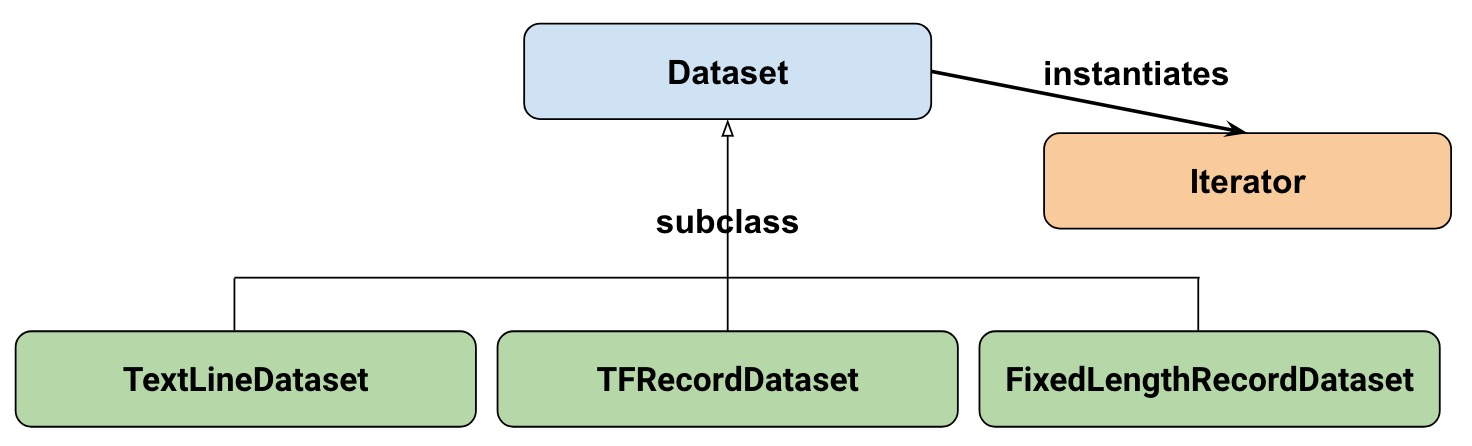

Ở bên dưới ta sử dụng method map của tf.data.TextLineDataset để chuyển dữ liệu sang dạng dict. Ngoài ra ta còn áp dụng các method khác như shuffle, repeat, batch,..

Để có thể hiểu rõ hơn về tf.data ta có thể tham khảo  [tại đây](https://www.tensorflow.org/guide/data). Thật ra tf.data khá giống với preprocessing trong sklearn. Nhưng khả năng là nó cung cấp nhiều metho hữu ích hơn, ko chỉ transform data mà còn giúp handle large data, remote data,..

Ngoai ra đây là một số ví dụ giúp bạn hiểu rõ hơn decode_csv [Python tensorflow.decode_csv() Examples](https://www.programcreek.com/python/example/90570/tensorflow.decode_csv)


In [ ]:
record_defaults = [ [1], ['object'], ['object']
                   , ['object'], ['object'], ['object'], ['object']]
columns_key = [ 'session_duration','time_context',
                      'artical_author', 'artical_name',
                     'artical_category ', 'operatingSystem', 'mobileDeviceBranding']
label_key = 'session_duration'
#features = {}
#abels = []
def read_dataset(filename, mode, batch_size = 512):
    def input_function():
        def decode_csv(value_column):
            columns = tf.io.decode_csv(value_column, record_defaults = record_defaults)
            features = dict(zip(columns_key,columns))
            labels = features.pop(label_key)
      
            return features, labels

        file_list = tf.io.gfile.glob(filename)
        # Dòng code này chuyển data sang dạng dict bằng cách áp dụng hàm decode_csv 
        # đối với mỗi row/record của file text ( trong trường hợp này là csv)
        dataset = tf.data.TextLineDataset(file_list).skip(1).map(decode_csv)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = None
            dataset = dataset.shuffle(buffer_size = 10*batch_size)
        else:
            num_epochs = 1

        dataset = dataset.repeat(num_epochs).batch(batch_size)
        dataset = tf.compat.v1.data.make_one_shot_iterator(dataset).get_next()
        return dataset
    return input_function

##Create feature columns

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
import tensorflow_hub as hub

# user_feature_column
# one-hot encoding
operatingSystem_column = feature_column.indicator_column(
    feature_column.categorical_column_with_vocabulary_list(
        key='operatingSystem', vocabulary_list= input_data.operatingSystem.unique()
    ))

# Embedding
mobileDeviceBranding_column = feature_column.embedding_column(
    feature_column.categorical_column_with_vocabulary_list(
        key = 'mobileDeviceBranding', vocabulary_list= input_data.mobileDeviceBranding.unique()),
        dimension=10
    ) 

user_feature_column = [operatingSystem_column, mobileDeviceBranding_column]

# item_feature_column
artical_author_column = feature_column.embedding_column(
    feature_column.categorical_column_with_vocabulary_list(
        key = 'artical_author',
        vocabulary_list = input_data.artical_author.unique()),20
)

artical_category_column = feature_column.indicator_column(
    feature_column.categorical_column_with_vocabulary_list(
        key = 'artical_category',
        vocabulary_list = input_data.artical_category.unique()
    )
)
# use pre-train model to get 50 dimensions embedding vector of artical_nam 
artical_name_column = hub.text_embedding_column(
    key="artical_name", 
    module_spec="https://tfhub.dev/google/nnlm-de-dim50/1",
    trainable=False
)

item_feature_column = [artical_author_column,artical_category_column]

#context_feature_column 
context_feature_column = feature_column.indicator_column(
    feature_column.categorical_column_with_vocabulary_list(
        key = 'time_context',
        vocabulary_list = input_data.time_context.unique()
    )
)

## Create the model and train/evaluate

In [ ]:
def model_function(features, labels, mode, params):
    #Compute final logits
    user_feature = tf.compat.v1.feature_column.input_layer(features, params['user_feature_columns']) 
    for i in params['user_hidden_units']:
        user_feature = tf.compat.v1.layers.Dense( units = i, activation = tf.nn.relu)(user_feature)
    user_logits = tf.compat.v1.layers.Dense( units = 20, activation = None)(user_feature)


    item_feature = tf.compat.v1.feature_column.input_layer(features, params['item_feature_columns']) 
    for i in params['item_hidden_units']:
        item_feature = tf.compat.v1.layers.Dense( units = i, activation = tf.nn.relu)(user_feature)
    item_logits = tf.compat.v1.layers.Dense(units = 20, activation = None)(item_feature)

    context_logits = tf.compat.v1.feature_column.input_layer(features, params['context_feature_columns']) 

    final_feature = tf.concat([user_logits,item_logits, context_logits],1)

    final_feature = tf.compat.v1.layers.Dense( units = 256, activation = tf.nn.relu)(final_feature)
    final_feature = tf.compat.v1.layers.Dropout(0.5)
    final_feature = tf.compat.v1.layers.Dense( units = 256, activation = tf.nn.relu)(final_feature)
    final_feature = tf.compat.v1.layers.Dropout(0.6)
    final_feature = tf.compat.v1.layers.Dense( units = 128, activation = tf.nn.relu)(final_feature)
    final_feature = tf.compat.v1.layers.Dropout(0.7)
    final_feature = tf.compat.v1.layers.Dense( units = 64, activation = tf.nn.relu)(final_feature)

    final_logits = tf.compat.v1.layers.Dense( units = 1, activation = None)(final_feature)
    

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions = final_logits)

    #Compute loss
    loss = tf.losses.mean_squared_error(labels, final_logits)

    # Compute evaluation matrics
    mae = tf.metrics.mean_squared_error(labels, final_logits)
    mse = tf.metrics.mean_absolute_error(labels, final_logits)
    metrics = {'mae':mae, 'mse':mse}

    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(mode, loss = loss, eval_metric_ops = metrics)

    #Create training
    assert mode == tf.estimator.ModeKeys.TRAIN
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

## Train and evaluate

In [ ]:
outdir = 'context_deep_learning_recomender'
import shutil
shutil.rmtree(outdir, ignore_errors = True)

estimator = tf.estimator.Estimator(
    model_fn=model_function,
    model_dir = outdir,
    params={
     'user_feature_columns': user_feature_column,
     'item_feature_columns': item_feature_column,
     'context_feature_columns': context_feature_column,
      'user_hidden_units': [256, 128, 64],
      'item_hidden_units': [256, 128, 64]
    })

train_spec = tf.estimator.TrainSpec(
    input_fn = read_dataset("train_data.csv", tf.estimator.ModeKeys.TRAIN),
    max_steps = 2000)

eval_spec = tf.estimator.EvalSpec(
    input_fn = read_dataset("test_data.csv", tf.estimator.ModeKeys.EVAL),
    steps = None,
    start_delay_secs = 30,
    throttle_secs = 60)

tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

# Build recomemender using keras

In [ ]:
from tensorflow import keras
from keras.backend import cast
params={
  'user_hidden_units': [256, 128, 64],
  'item_hidden_units': [256, 128, 64]
}

user_feature_layer = keras.layers.DenseFeatures(user_feature_column) 
user_feature_input = {
    'operatingSystem':tf.keras.Input((1,), dtype=tf.dtypes.string, name='operatingSystem'),
    'mobileDeviceBranding':tf.keras.Input((1,), dtype=tf.dtypes.string, name='mobileDeviceBranding')
}
user_input = user_feature_layer(user_feature_input)
for i in params['user_hidden_units']:
    user_input = keras.layers.Dense( units = i, activation = 'relu')(user_input)
user_logits = keras.layers.Dense( units = 20, activation = None)(user_input)
user_logits = keras.layers.Lambda(lambda x:cast(x, 'float32'), name='user_logits')(user_logits)


item_feature_layer = keras.layers.DenseFeatures(item_feature_column) 
item_feature_input = {
    'artical_author':tf.keras.Input((1,), dtype=tf.dtypes.string, name='artical_author'),
    'artical_category':tf.keras.Input((1,), dtype=tf.dtypes.string, name='artical_category')
    
}
item_input = item_feature_layer(item_feature_input)
for i in params['item_hidden_units']:
    item_input =keras.layers.Dense( units = i, activation = 'relu')(item_input)
item_logits =keras.layers.Dense(units = 20, activation = None)(item_input)
item_logits = keras.layers.Lambda(lambda x:cast(x, 'float32'), name='item_logits')(item_logits)


context_feature_layers = keras.layers.DenseFeatures(context_feature_column) 
context_feature_input = {
    'time_context':tf.keras.Input((1,), dtype=tf.dtypes.string, name='time_context')
}
context_input = context_feature_layers(context_feature_input)
final_feature = keras.layers.concatenate([user_logits,item_logits],-1)

final_feature = keras.layers.Dense( units = 256, activation = tf.nn.relu)(final_feature)
#final_feature = keras.layers.Dropout(0.5)
final_feature = keras.layers.Dense( units = 256, activation = tf.nn.relu)(final_feature)
#final_feature = keras.layers.Dropout(0.6)
final_feature = keras.layers.Dense( units = 128, activation = tf.nn.relu)(final_feature)
#final_feature = keras.layers.Dropout(0.7)
final_feature = keras.layers.Dense( units = 64, activation = tf.nn.relu)(final_feature)

final_logits = keras.layers.Dense( units = 1, activation = None)(final_feature)
model = tf.keras.Model([user_input, item_input], final_logits)


In [ ]:
model = tf.keras.Model([user_features, item_features, context_features], final_logits)

model.compile(loss='mean_squared_error', optimizer='adam',
              metrics = ['mse','mae'])
